In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
from tqdm.notebook import tqdm
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

import torchvision
from torchvision.models import alexnet
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score
import os

# **Device**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# **Dataset**

In [3]:
df_train = pd.read_csv('/dataset/fashion-mnist_train.csv')
df_test = pd.read_csv('/dataset/fashionmnist/fashion-mnist_test.csv')

# **Label**

In [4]:
print(df_train['label'].unique())
unique_count = df_train['label'].nunique()
print("Number of labels: ", unique_count)

[2 9 6 0 3 4 5 8 7 1]
Number of labels:  10


# **Data Splitting and Reshaping for CNN**

In [5]:
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_train = X_train.values.reshape(-1, 28, 28, 1)

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']
X_test = X_test.values.reshape(-1, 28, 28, 1)

# **Image Samples**

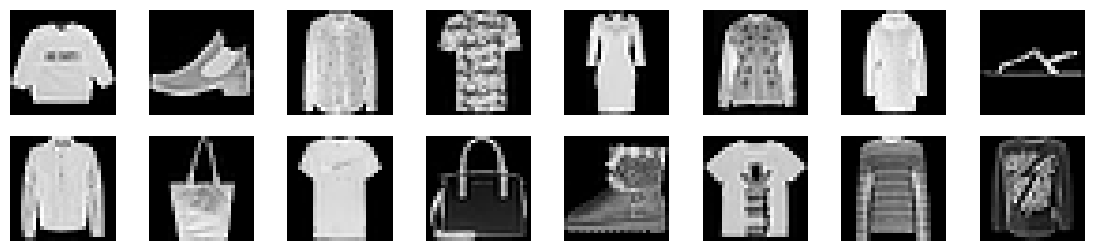

In [6]:
fig, ax = plt.subplots(ncols=8, nrows=2, figsize=(14, 3))
n = 0
for i in range(2):
    for j in range(8):
        ax[i][j].imshow(X_train[n], cmap='gray')
        ax[i][j].axis(False)
        n += 1
plt.show()

# **Data Processing and Data Augmentation**

In [7]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

X_train_tesor = torch.tensor(data=X_train, dtype=torch.float32)
y_train_tesor = torch.tensor(data=y_train, dtype=torch.long)

X_test_tesor = torch.tensor(data=X_test, dtype=torch.float32)
y_test_tesor = torch.tensor(data=y_test, dtype=torch.long)

def random_horizontal_flip(probability=0.5):
    return transforms.RandomHorizontalFlip(p=probability)

def random_rotation(degrees=(-25, 25)):
    return transforms.RandomRotation(degrees)

def random_resized_crop(size=28, scale=(0.8, 1.0), ratio=(1.0, 1.0)):
    return transforms.RandomResizedCrop(size, scale=scale, ratio=ratio)

def color_jitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2):
    return transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

def random_grayscale(probability=0.2):
    return transforms.RandomGrayscale(p=probability)

# Create a composition of augmentations
transform_aug = transforms.Compose([
    random_horizontal_flip(),
    random_rotation(),
    random_resized_crop(),
    color_jitter(),
    random_grayscale(),
])

X_train_tesor /= 255.0
X_test_tesor /= 255.0

augm_X_train = []
for image in X_train_tesor:
    aug_image = transform_aug(image)
    augm_X_train.append(aug_image)

augm_X_train = torch.stack(augm_X_train)
X_train_combined = torch.cat((X_train_tesor, augm_X_train), dim=0)
y_train_combined = torch.cat((y_train_tesor, y_train_tesor), dim=0)


dataset_train = TensorDataset(X_train_combined, y_train_combined)
dataset_test = TensorDataset(X_test_tesor, y_test_tesor)

batch_size = 64
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, shuffle=False)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# **Improved Version of the VGG8-like Architecture**

In [8]:
class VGG8(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG8, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),  # Adjust the input size based on your data
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create the improved model
model = VGG8()
model.to(device)


VGG8(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True

# **Training and Evaluating**

In [9]:
def fit(model, loss_func, opt, train_loader, test_loader, epochs, scheduler):
    train_loss_hist = []
    test_loss_hist = []
    accuracy_hist = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_loss = 0
        for xb, yb in tqdm(train_loader, desc=f'train {epoch+1} epoch'):
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            avg_loss += loss.item()
        train_loss_hist.append(avg_loss / len(train_loader))
        scheduler.step()

        with torch.no_grad():
            model.eval()
            y_pred = []
            y_true = []
            avg_loss = 0
            for x, y in tqdm(test_loader, desc=f'test {epoch+1} epoch'):
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_func(output, y)
                avg_loss += loss.item()
                logit = torch.softmax(output, dim=1)
                _, pred = torch.max(logit, dim=1)
                y_pred.append(pred.item())
                y_true.append(y.item())
            test_loss_hist.append(avg_loss / len(test_loader))
            accuracy_hist.append(accuracy_score(y_true, y_pred))

        train_loss = round(train_loss_hist[-1], 5)
        test_loss = round(test_loss_hist[-1], 5)
        accuracy = round(accuracy_hist[-1], 5)
        lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch {epoch+1}'st: train_loss = {train_loss}, test_loss = {test_loss}, accuracy = {accuracy}, lr = {lr}")

    return train_loss_hist, test_loss_hist, accuracy_hist

# **Configuring and Running the Training Process**

In [10]:
# Usage
epochs = 20  # You can set a large number, and early stopping will handle it.
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())
opt = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.MultiStepLR(opt, milestones=[10], gamma=0.3)

hist = fit(model, loss_func, opt, train_loader, test_loader, epochs, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

train 1 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 1 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1'st: train_loss = 0.73563, test_loss = 0.33802, accuracy = 0.8772, lr = 0.0001


train 2 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 2 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 2'st: train_loss = 0.47348, test_loss = 0.27957, accuracy = 0.9015, lr = 0.0001


train 3 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 3 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 3'st: train_loss = 0.41031, test_loss = 0.25159, accuracy = 0.9056, lr = 0.0001


train 4 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 4 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 4'st: train_loss = 0.37154, test_loss = 0.23199, accuracy = 0.9157, lr = 0.0001


train 5 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 5 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 5'st: train_loss = 0.34333, test_loss = 0.21219, accuracy = 0.9215, lr = 0.0001


train 6 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 6 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 6'st: train_loss = 0.31969, test_loss = 0.21204, accuracy = 0.9235, lr = 0.0001


train 7 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 7 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 7'st: train_loss = 0.30325, test_loss = 0.20371, accuracy = 0.9255, lr = 0.0001


train 8 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 8 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 8'st: train_loss = 0.2863, test_loss = 0.19039, accuracy = 0.929, lr = 0.0001


train 9 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 9 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 9'st: train_loss = 0.27014, test_loss = 0.19138, accuracy = 0.9301, lr = 0.0001


train 10 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 10 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 10'st: train_loss = 0.25727, test_loss = 0.1839, accuracy = 0.9314, lr = 3e-05


train 11 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 11 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 11'st: train_loss = 0.21415, test_loss = 0.18323, accuracy = 0.9343, lr = 3e-05


train 12 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 12 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 12'st: train_loss = 0.2017, test_loss = 0.18059, accuracy = 0.9338, lr = 3e-05


train 13 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 13 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 13'st: train_loss = 0.19542, test_loss = 0.18385, accuracy = 0.9357, lr = 3e-05


train 14 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 14 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 14'st: train_loss = 0.18723, test_loss = 0.18468, accuracy = 0.9355, lr = 3e-05


train 15 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 15 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 15'st: train_loss = 0.18071, test_loss = 0.18507, accuracy = 0.9345, lr = 3e-05


train 16 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 16 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 16'st: train_loss = 0.17474, test_loss = 0.18385, accuracy = 0.9357, lr = 3e-05


train 17 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 17 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 17'st: train_loss = 0.16782, test_loss = 0.18668, accuracy = 0.9348, lr = 3e-05


train 18 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 18 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 18'st: train_loss = 0.16225, test_loss = 0.18563, accuracy = 0.9376, lr = 3e-05


train 19 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 19 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 19'st: train_loss = 0.15535, test_loss = 0.1852, accuracy = 0.9379, lr = 3e-05


train 20 epoch:   0%|          | 0/1875 [00:00<?, ?it/s]

test 20 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 20'st: train_loss = 0.15118, test_loss = 0.19095, accuracy = 0.9365, lr = 3e-05


# **Training History**

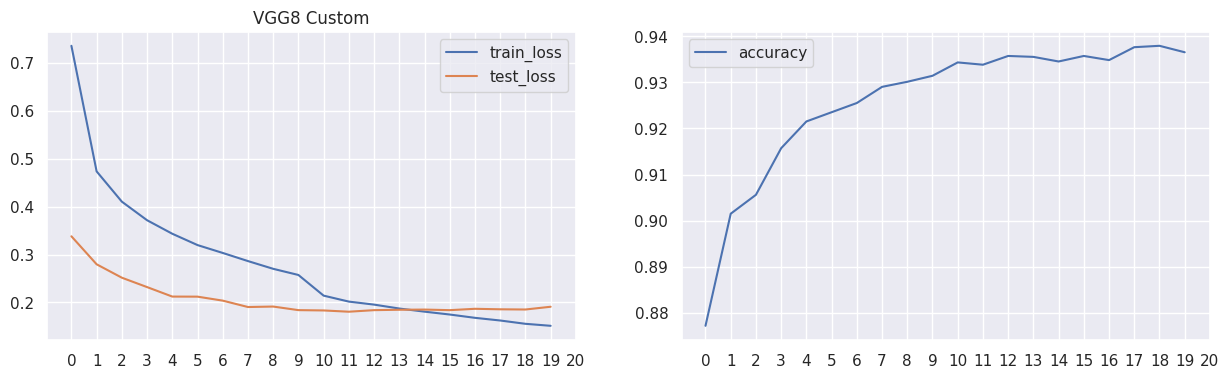

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
x = range(epochs)
sns.lineplot(x=x, y=hist[0], label='train_loss', ax=ax[0])
sns.lineplot(x=x, y=hist[1], label='test_loss', ax=ax[0])

sns.lineplot(x=x, y=hist[2], label='accuracy', ax=ax[1])

ax[0].set_title('VGG8 Custom')
ax[0].set_xticks(range(epochs+1))
ax[1].set_xticks(range(epochs+1))
plt.legend()
plt.show()

# **Save PyTorch model**

In [12]:
# Check if the directory exists, and if not, create it
if not os.path.exists("models"):
    os.makedirs("models")
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'models/fashion_model.pth')